In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import transforms, datasets
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader
import torch.nn.init
from torchvision.transforms.functional import to_pil_image
from skimage.util import invert

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [4]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [5]:
#mnist download
mnist_train = datasets.MNIST(root='MNIST_data/', 
                          train=True, 
                          transform=transforms.ToTensor(), 
                          download=True)

mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False, 
                         transform=transforms.ToTensor(), 
                         download=True)


data_loader = DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [7]:
#CNN model architecture
class CNN(nn.Module):

    def __init__(self):
        super(CNN,self).__init__()

        self.keep_prob=0.5

        self.layer1=nn.Sequential(
            nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.layer2=nn.Sequential(
            nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.layer3=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2,padding=1)
        )

        self.fc1=nn.Linear(128*4*4,625,bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)

        self.layer4=nn.Sequential(
            self.fc1,
            nn.ReLU(),
            nn.Dropout2d(p=1-self.keep_prob)
        )

        self.fc2=nn.Linear(625,10,bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self,x):
        out=self.layer1(x)
        out=self.layer2(out)
        out=self.layer3(out)
        out=out.view(out.size(0),-1)
        out=self.layer4(out)
        out=self.fc2(out)
        return out


In [8]:
model=CNN().to(device)
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

total_batch = len(data_loader)

#train
for epoch in range(15):
    avg_cost=0
    for X,Y in data_loader:

        X=X.to(device)
        Y=Y.to(device)
        optimizer.zero_grad()
        hypothesis=model(X)
        cost=criterion(hypothesis,Y)
        cost.backward()
        optimizer.step()

        avg_cost+=cost/total_batch
    print(avg_cost)


c:\Users\hwang\anaconda3\Lib\site-packages\torch\nn\functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


tensor(0.2007, grad_fn=<AddBackward0>)
tensor(0.0527, grad_fn=<AddBackward0>)
tensor(0.0398, grad_fn=<AddBackward0>)
tensor(0.0305, grad_fn=<AddBackward0>)
tensor(0.0252, grad_fn=<AddBackward0>)
tensor(0.0233, grad_fn=<AddBackward0>)
tensor(0.0189, grad_fn=<AddBackward0>)
tensor(0.0153, grad_fn=<AddBackward0>)
tensor(0.0150, grad_fn=<AddBackward0>)
tensor(0.0122, grad_fn=<AddBackward0>)
tensor(0.0116, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
tensor(0.0083, grad_fn=<AddBackward0>)
tensor(0.0096, grad_fn=<AddBackward0>)
tensor(0.0093, grad_fn=<AddBackward0>)


tensor(7)
tensor(2)
tensor(1)
tensor(0)
tensor(4)
tensor(1)
tensor(4)
tensor(9)
tensor(5)
tensor(9)
Accuracy: 0.9865999817848206


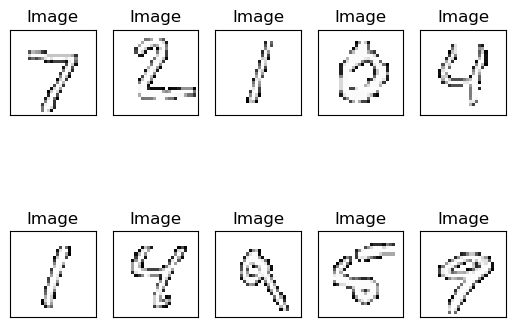

In [27]:
#check accuracy
with torch.no_grad():
    X_test = mnist_test.test_data.view(len(mnist_test), 1, 28, 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = model(X_test)
    for i in range(10):
        xplt=X_test[i]
        xplt=to_pil_image(xplt)
        plt.subplot(2, 5, i+1)
        plt.title('Image')
        plt.xticks([]) 
        plt.yticks([])
        plt.imshow(xplt,cmap='gray_r')
        print(torch.argmax(prediction,1)[i])

    correct_prediction = torch.argmax(prediction, 1) == Y_test

    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())